In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations
from utils import get_device, plot_training_progress
from model import GCNNetwork, CEALNetwork, PNANetwork, save_model, load_model

from args import *
from utils import *

from tqdm import tqdm
from IPython.display import clear_output as ipyclear

/home/catcolia/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare the dataset

In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

Model training parameters

In [4]:
def save_result_data(
    all_args,
    epoch,
    model,
    train_losses,
    val_losses,
    test_losses,
    test_loader,
    test_dataset,
    device,
    optimizer,
    scheduler,
    result_path,
    regression_title="Model Regression",
    save_split=100,
    training=False,
    *args,
    **kwargs
):
    if epoch % save_split != 0 and training is True:
        return

    print("Saving data...")
    save_hyper_parameter(all_args, result_path)
    save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
    test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

    # Reverse normalization of test_out and y
    min, max = get_data_scale(all_args)
    test_y = reverse_min_max_scalar_1d(test_y, min, max)
    test_out = reverse_min_max_scalar_1d(test_out, min, max)
    loss = (test_out.squeeze() - test_y).abs().mean()
    print("MAE loss: ", loss.item())

    # save results
    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path,threshold=0.2)
    save_regression_result(test_out, test_y, result_path)
    plot_regression_result(regression_title, result_path, plotfilename="regression_figure.jpeg")

    # save model
    print("Saving model...")
    save_model(result_path, model, epoch, loss, optimizer, scheduler)

    return loss

In [3]:
model_name = "PNA"
model_network = model_name + "Network"
model_args = args[model_name]

In [5]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = get_device()
# device = torch.device("cpu")

in_dim = train_dataset[0].x.shape[-1]
deg = generate_deg(train_dataset).float()
deg = deg.to(device)
model = PNANetwork(deg, in_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=model_args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode=model_args["sche_mode"], factor=model_args["sche_factor"], patience=model_args["sche_patience"], min_lr=model_args["sche_min_lr"]
)

29274 6273 6272


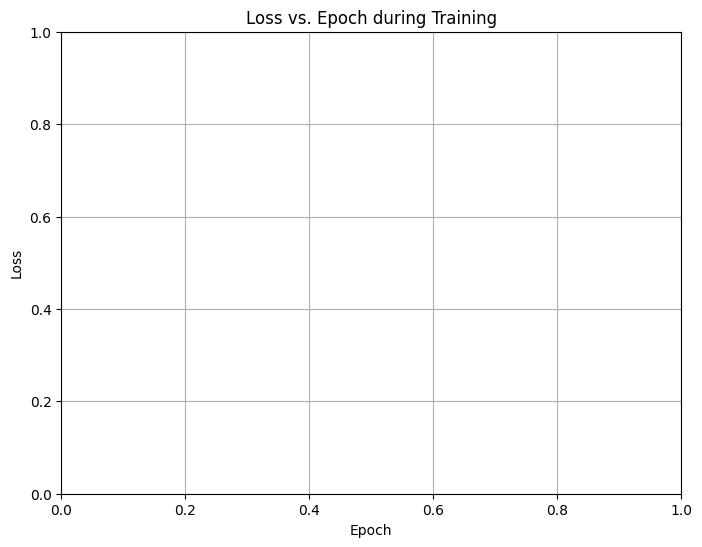

In [6]:
result_path = create_result_folder(osp.join("./results", model_name))
test_best_loss = None
epoch = None

save_split = 100
show_plot_split = 50

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

Model training

epoch:49 train:0.0153 valid:0.0197 test:0.0197 lr:0.01 best_test:0.0131:   0%|          | 50/10001 [03:19<11:17:50,  4.09s/it]

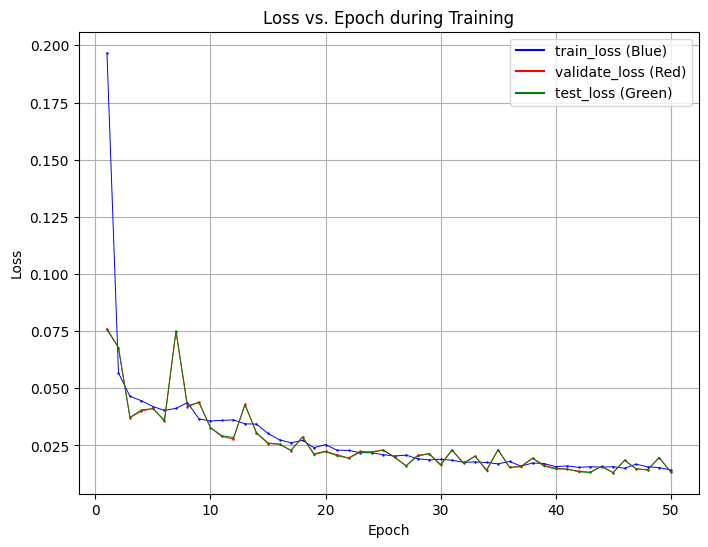

epoch:99 train:0.0112 valid:0.0103 test:0.0105 lr:0.01 best_test:0.0099:   1%|          | 100/10001 [06:45<11:26:24,  4.16s/it]

Saving data...
MAE loss:  0.10214538872241974


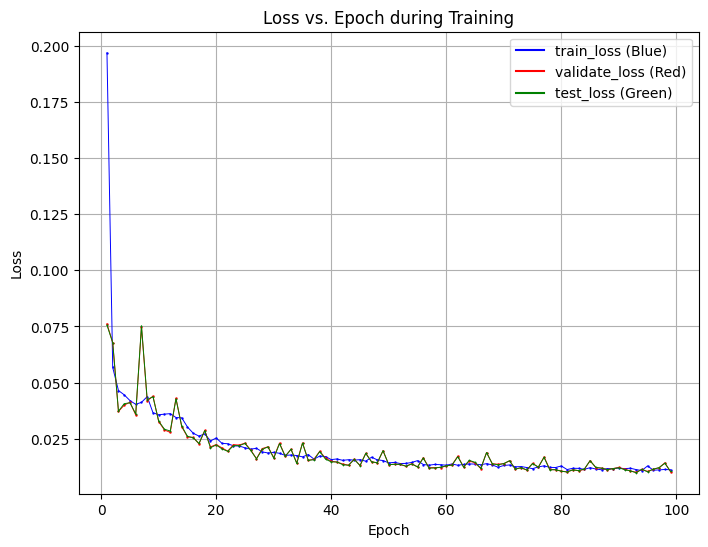

MAE=  0.10214539125065082
Saving model...


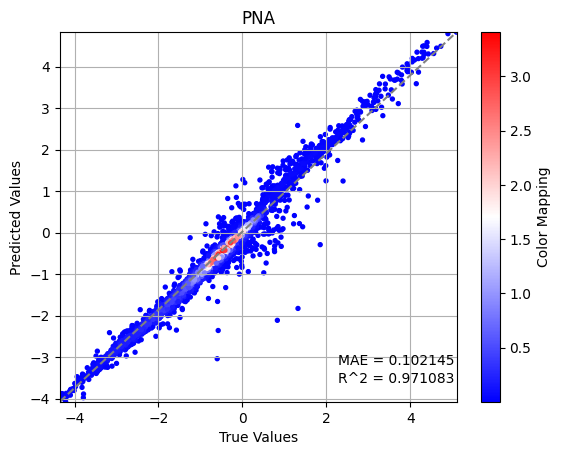

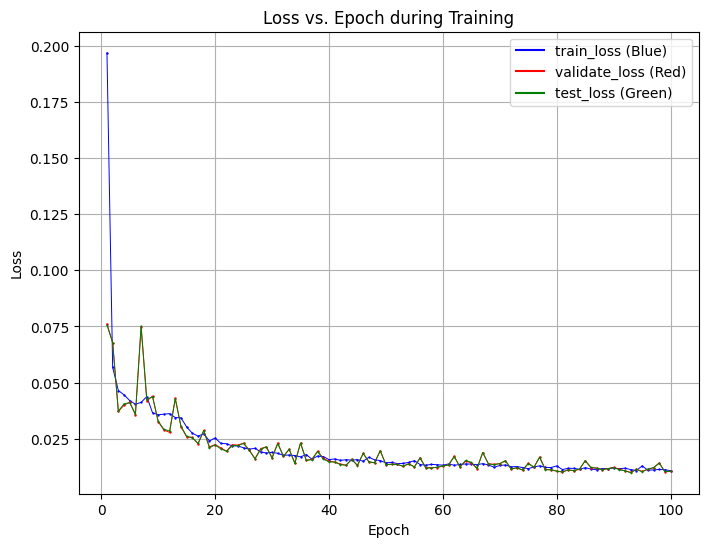

epoch:149 train:0.0101 valid:0.0136 test:0.0139 lr:0.0085 best_test:0.0088:   1%|▏         | 150/10001 [10:15<11:30:12,  4.20s/it]

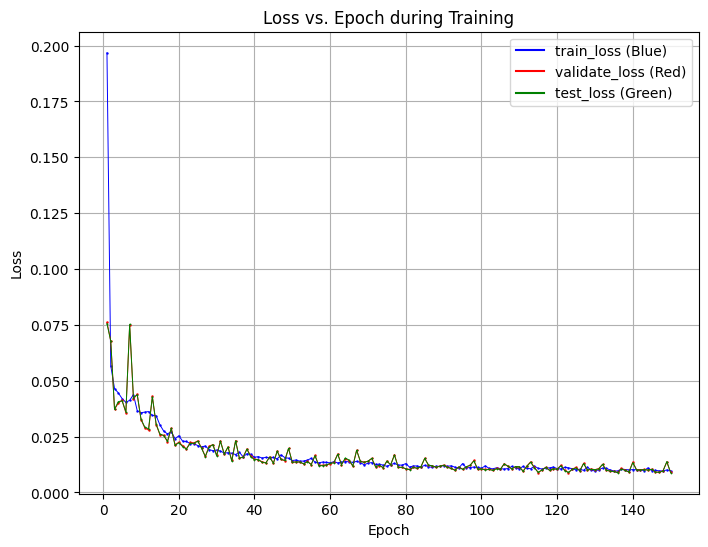

epoch:199 train:0.0088 valid:0.0105 test:0.0104 lr:0.0085 best_test:0.0083:   2%|▏         | 200/10001 [13:43<11:16:18,  4.14s/it]

Saving data...
MAE loss:  0.10193168371915817


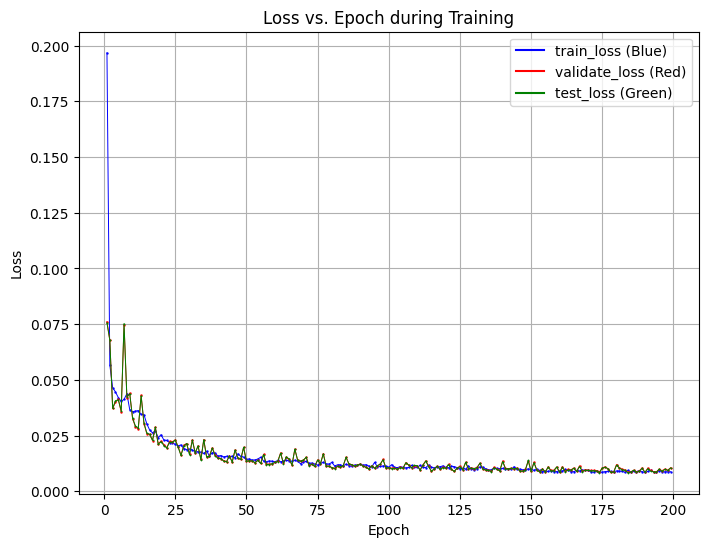

MAE=  0.10193168862264988
Saving model...


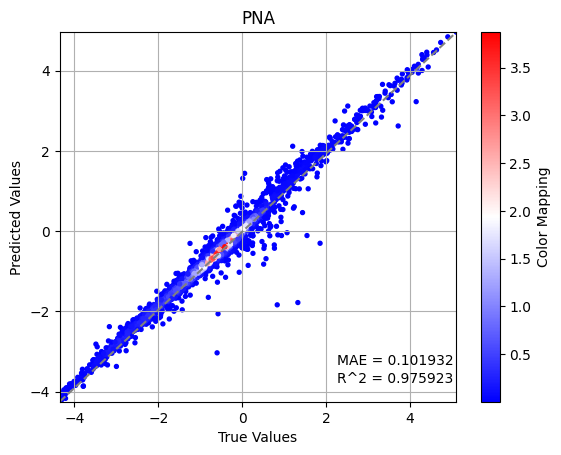

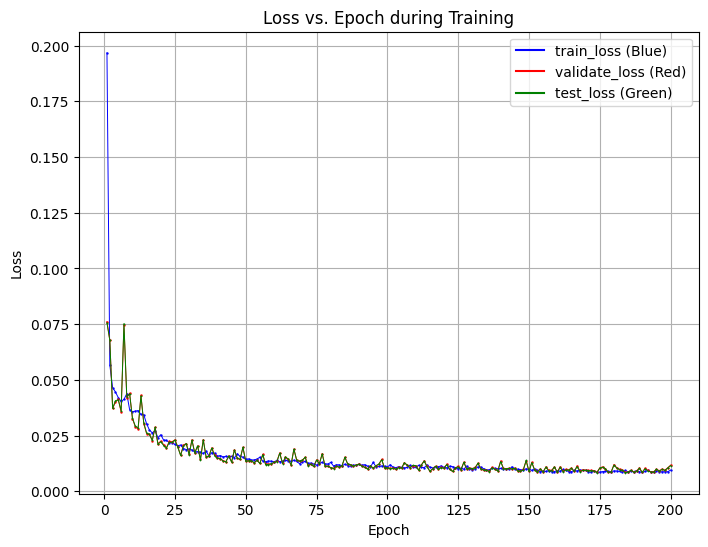

epoch:249 train:0.0079 valid:0.0084 test:0.0084 lr:0.0085 best_test:0.0078:   2%|▏         | 250/10001 [17:13<11:22:25,  4.20s/it]

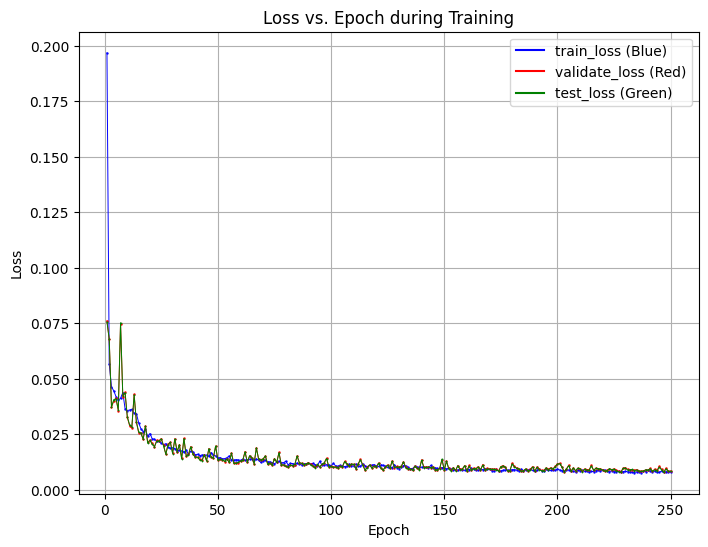

epoch:299 train:0.007 valid:0.0078 test:0.0076 lr:0.007225 best_test:0.0074:   3%|▎         | 300/10001 [20:41<11:20:06,  4.21s/it] 

Saving data...
MAE loss:  0.07416331022977829


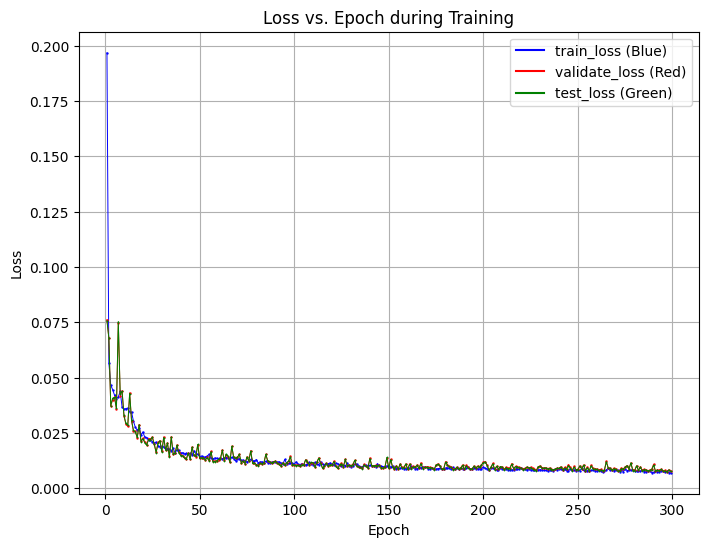

MAE=  0.07416331205729751
Saving model...


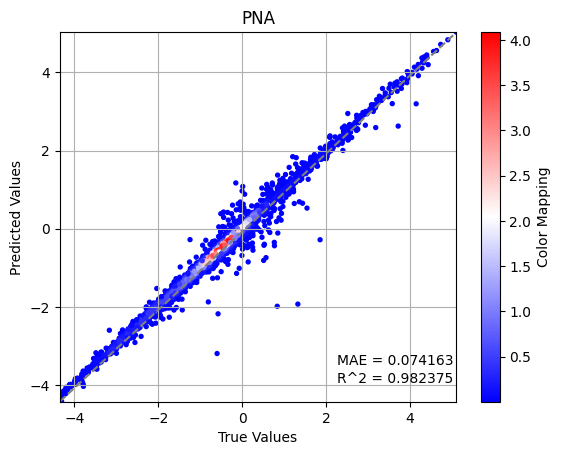

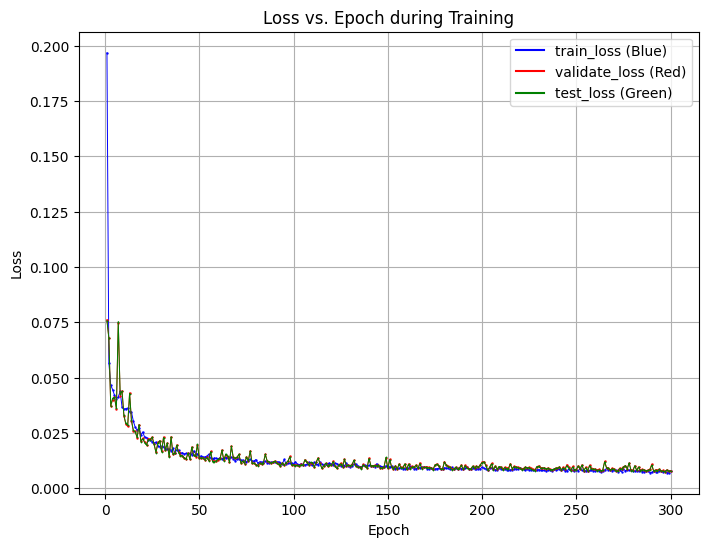

epoch:349 train:0.0069 valid:0.008 test:0.0078 lr:0.007225 best_test:0.0071:   3%|▎         | 350/10001 [24:20<11:07:42,  4.15s/it] 

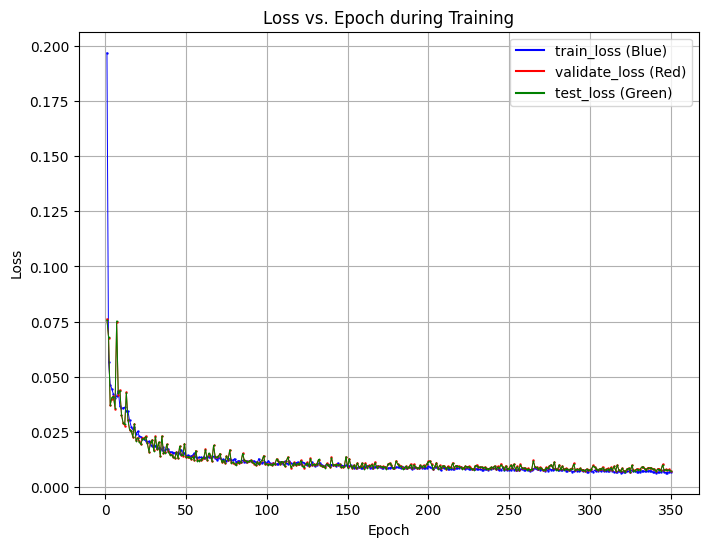

epoch:399 train:0.0063 valid:0.0069 test:0.0069 lr:0.00522006 best_test:0.0069:   4%|▍         | 400/10001 [27:48<11:09:38,  4.18s/it]

Saving data...
MAE loss:  0.06741304695606232


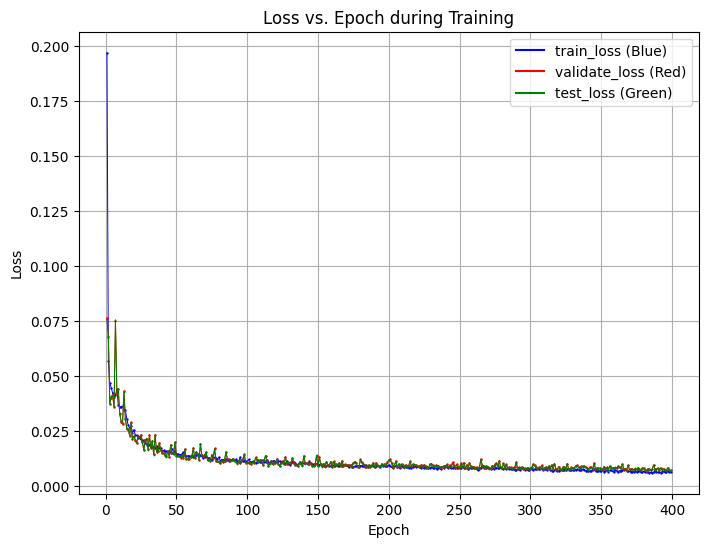

MAE=  0.06741304689049585
Saving model...


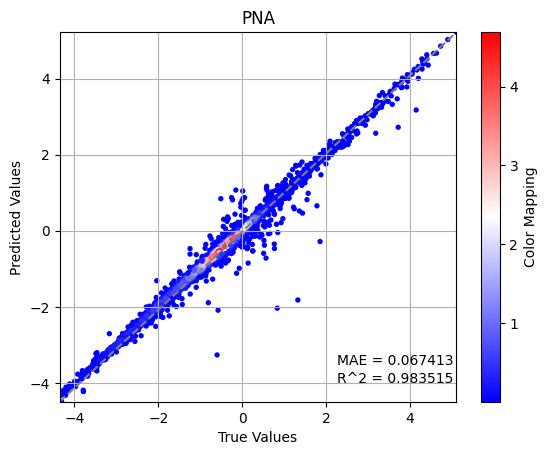

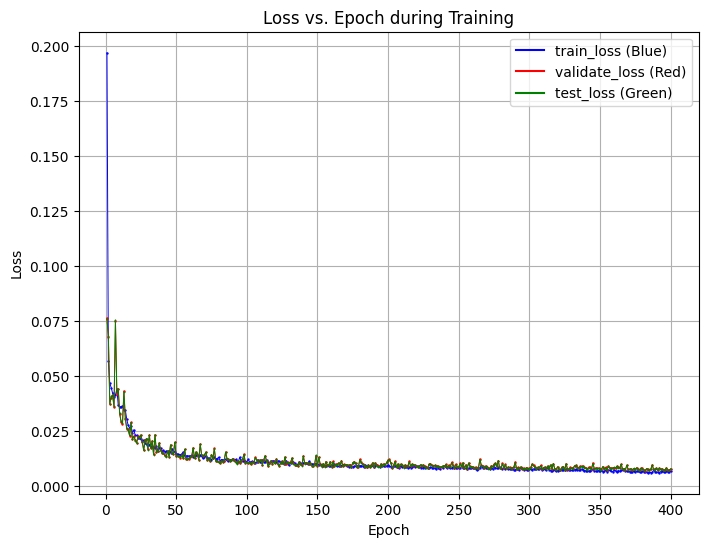

epoch:449 train:0.0058 valid:0.0072 test:0.0071 lr:0.00443705 best_test:0.0067:   4%|▍         | 450/10001 [31:19<11:01:14,  4.15s/it]

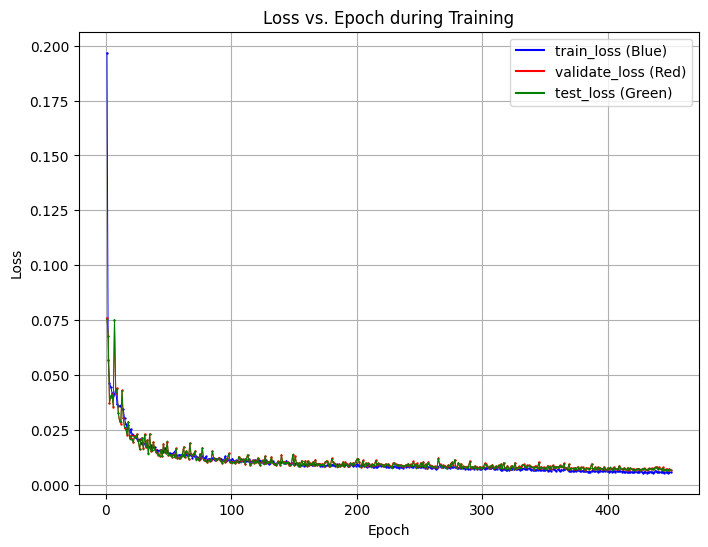

epoch:499 train:0.0049 valid:0.0068 test:0.0067 lr:0.0037715 best_test:0.0064:   5%|▍         | 500/10001 [34:48<11:00:22,  4.17s/it] 

Saving data...
MAE loss:  0.06496795266866684


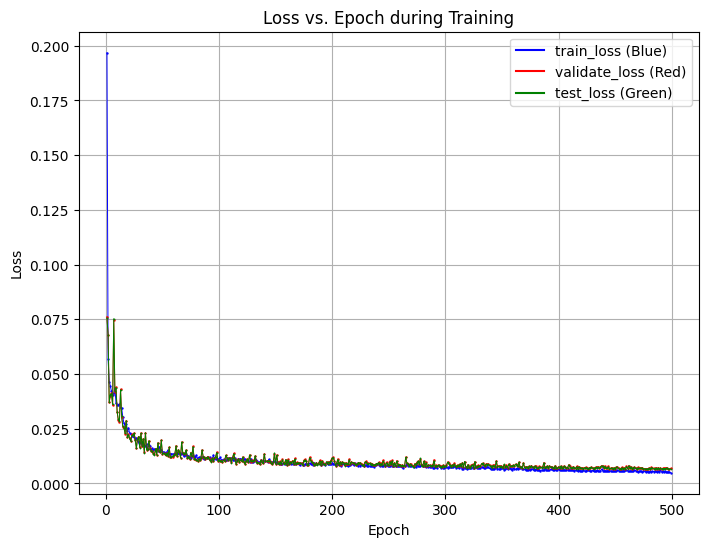

MAE=  0.06496795192870534
Saving model...


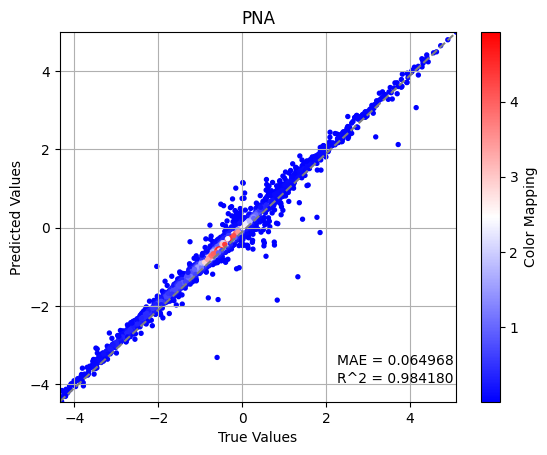

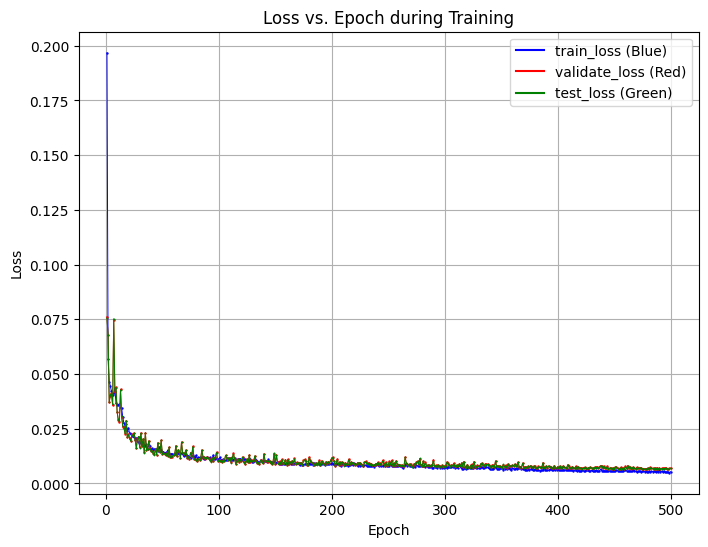

epoch:549 train:0.0051 valid:0.0066 test:0.0065 lr:0.0037715 best_test:0.0064:   5%|▌         | 550/10001 [38:19<10:58:46,  4.18s/it]

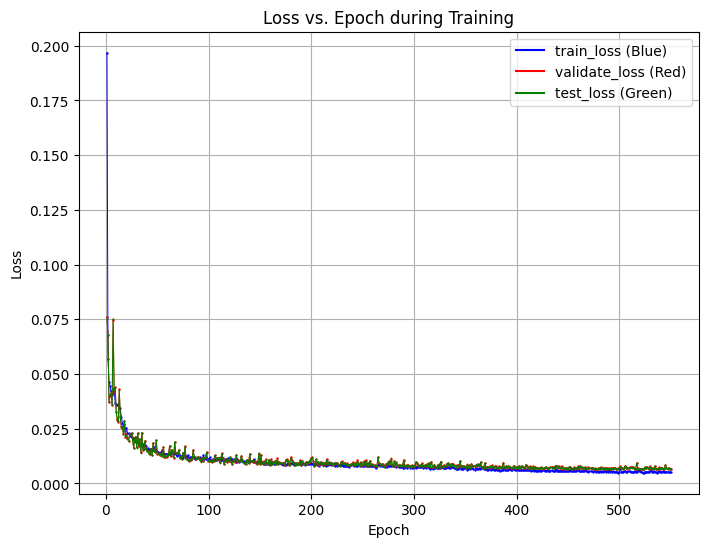

epoch:599 train:0.0048 valid:0.007 test:0.007 lr:0.00272491 best_test:0.0063:   6%|▌         | 600/10001 [41:48<10:55:57,  4.19s/it]  

Saving data...
MAE loss:  0.06816104799509048


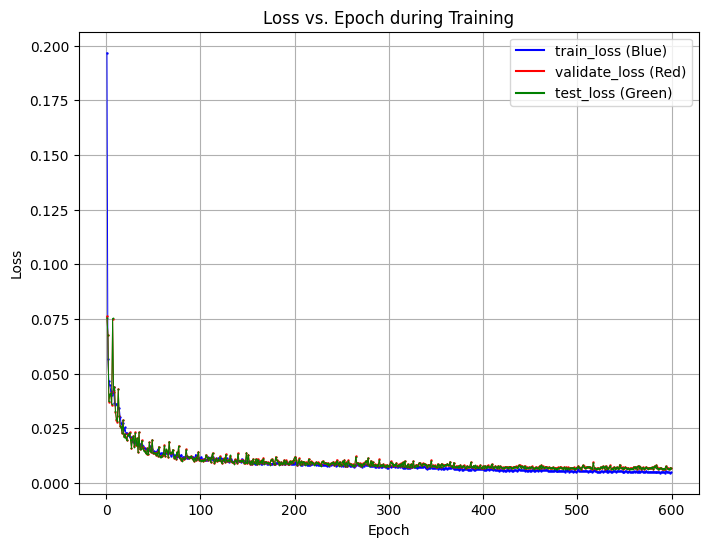

MAE=  0.06816104474137276
Saving model...


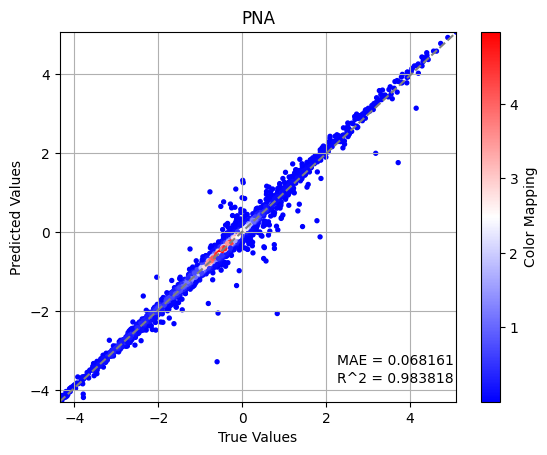

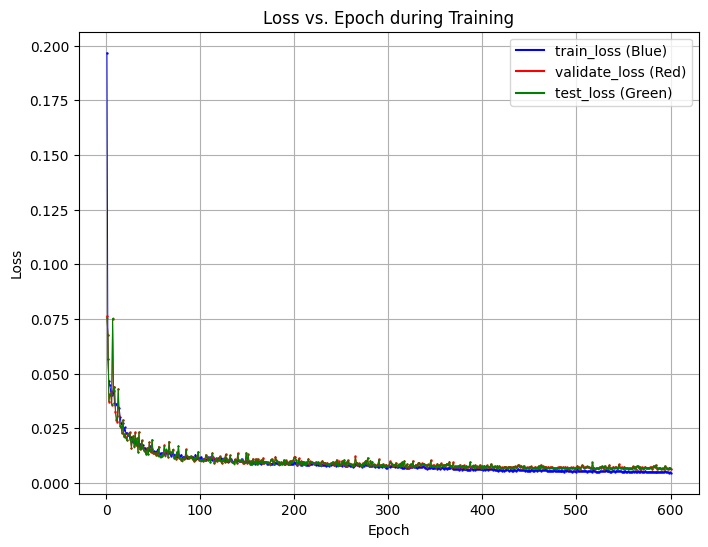

epoch:649 train:0.0047 valid:0.0067 test:0.0067 lr:0.00231617 best_test:0.0063:   6%|▋         | 650/10001 [45:19<10:52:02,  4.18s/it]

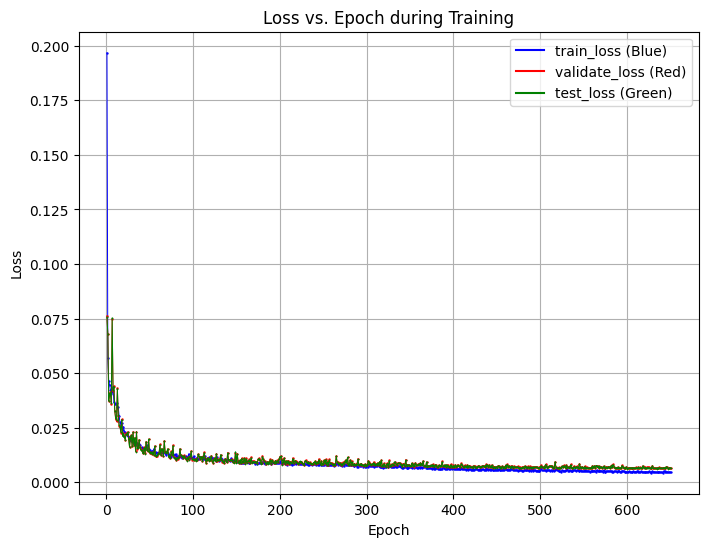

epoch:699 train:0.0046 valid:0.0069 test:0.0069 lr:0.00196874 best_test:0.0061:   7%|▋         | 700/10001 [48:49<10:52:56,  4.21s/it]

Saving data...
MAE loss:  0.06690432876348495


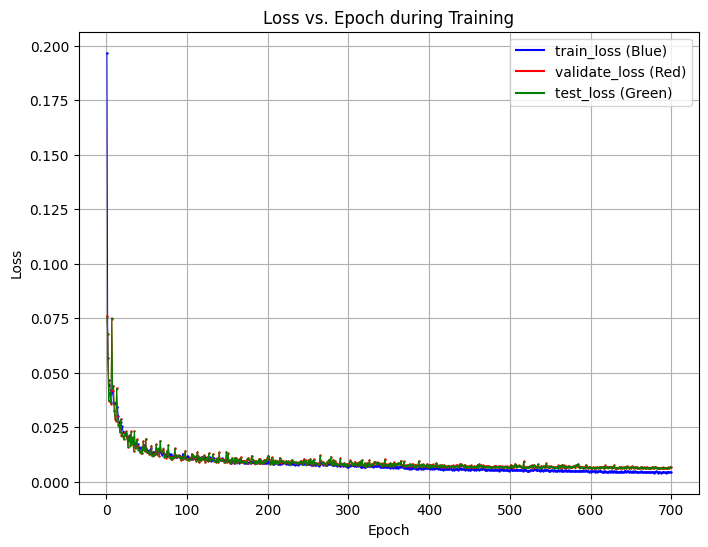

MAE=  0.06690433001169484
Saving model...


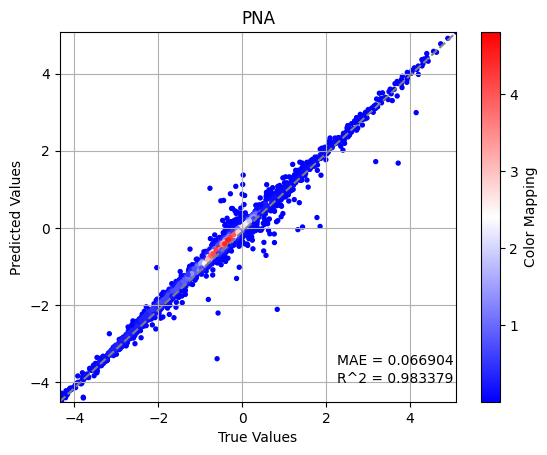

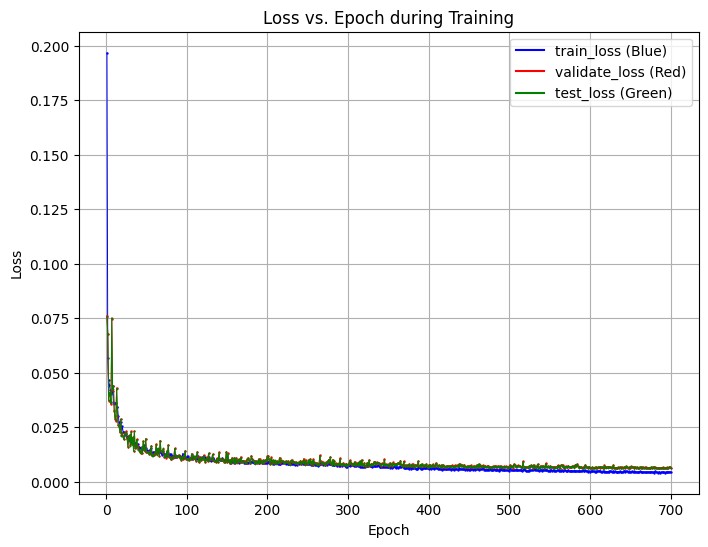

epoch:749 train:0.0042 valid:0.0064 test:0.0063 lr:0.00142242 best_test:0.006:   7%|▋         | 750/10001 [53:06<10:44:19,  4.18s/it] 

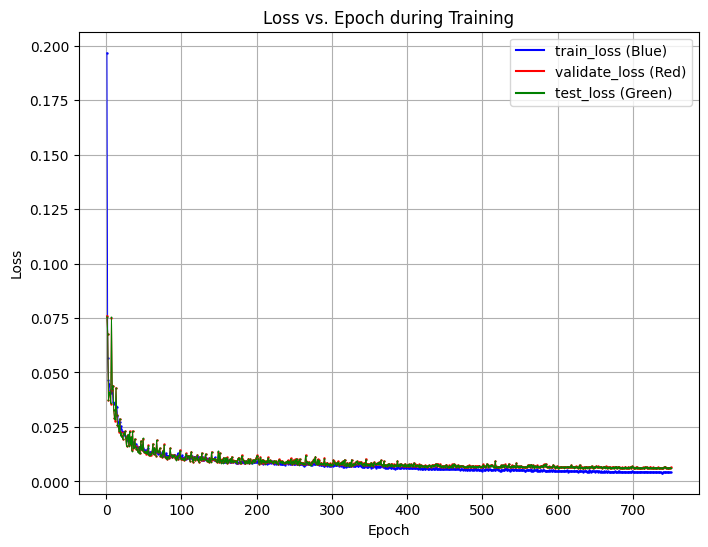

epoch:799 train:0.0039 valid:0.0061 test:0.006 lr:0.0010277 best_test:0.006:   8%|▊         | 800/10001 [56:36<10:42:49,  4.19s/it]  

Saving data...
MAE loss:  0.058617692440748215


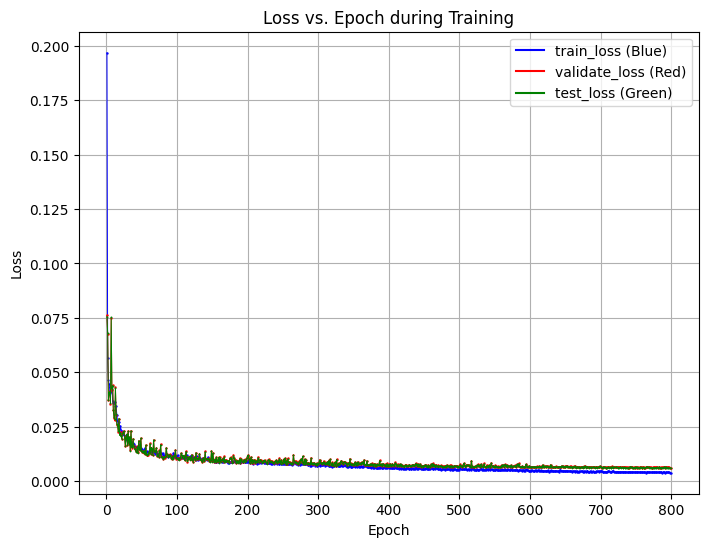

MAE=  0.05861769302020727
Saving model...


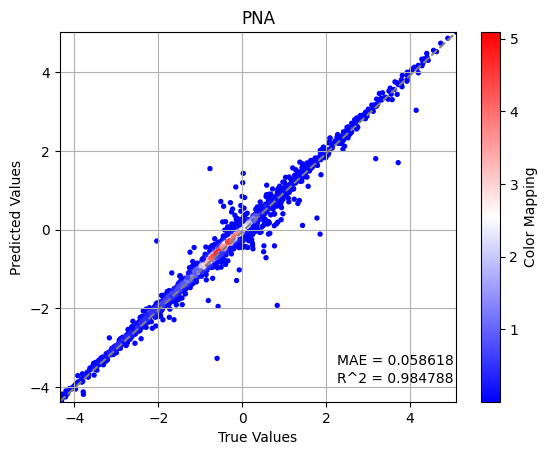

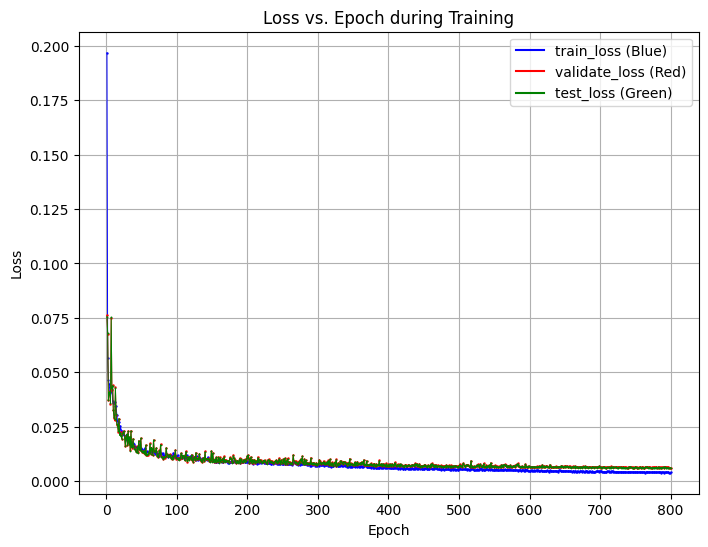

epoch:849 train:0.004 valid:0.0064 test:0.0062 lr:0.00087354 best_test:0.006:   8%|▊         | 850/10001 [1:00:07<10:43:17,  4.22s/it] 

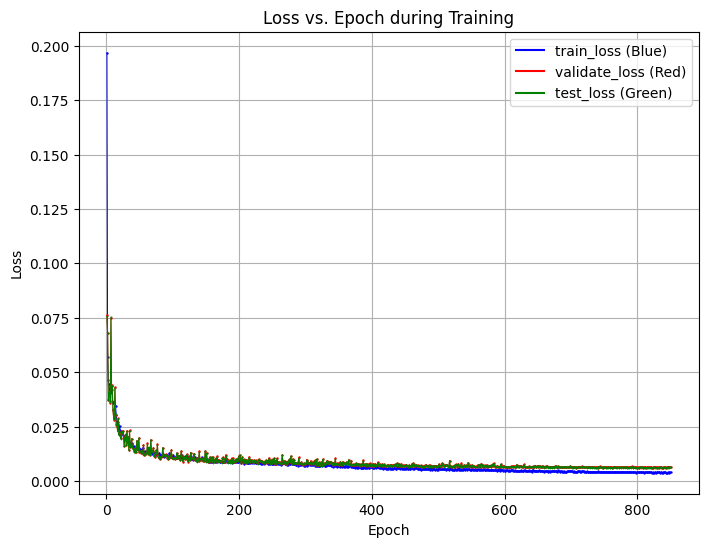

epoch:899 train:0.0037 valid:0.0062 test:0.006 lr:0.00063113 best_test:0.006:   9%|▉         | 900/10001 [1:03:37<10:32:21,  4.17s/it] 

Saving data...
MAE loss:  0.05885706841945648


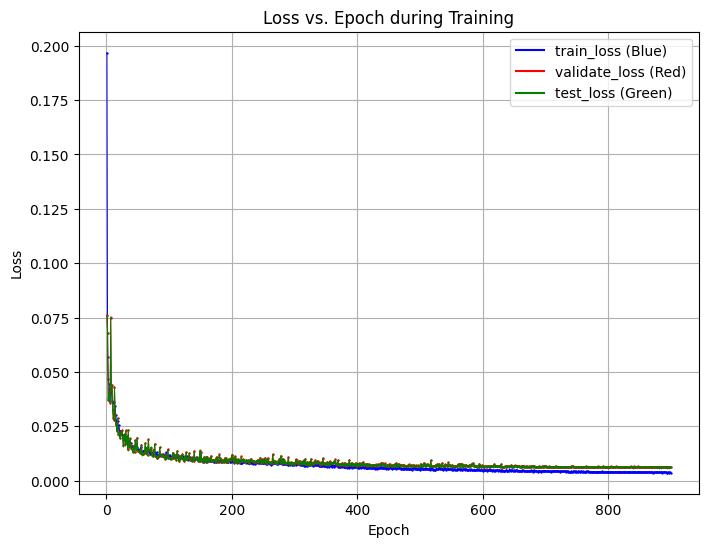

MAE=  0.058857066625750964
Saving model...


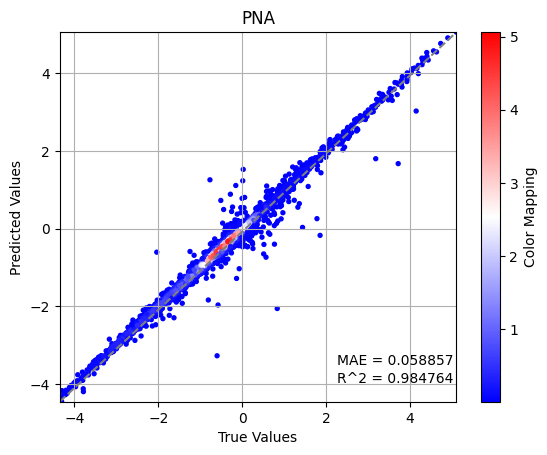

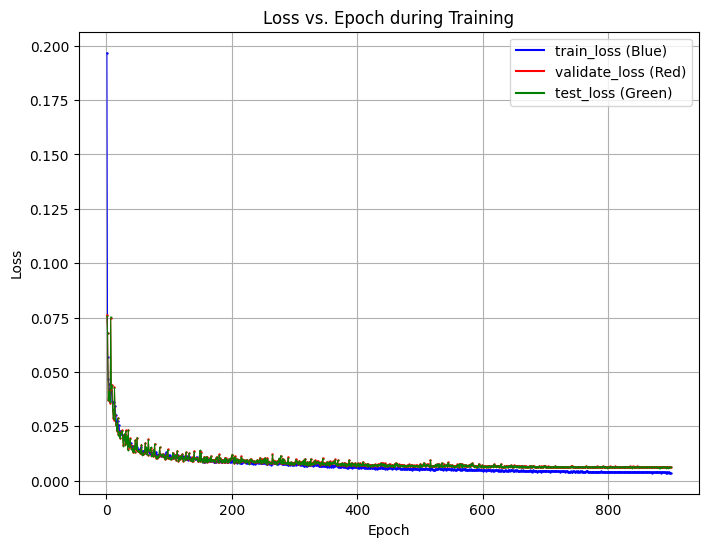

epoch:949 train:0.0037 valid:0.0062 test:0.0061 lr:0.00045599 best_test:0.006:   9%|▉         | 950/10001 [1:07:09<10:34:12,  4.20s/it]

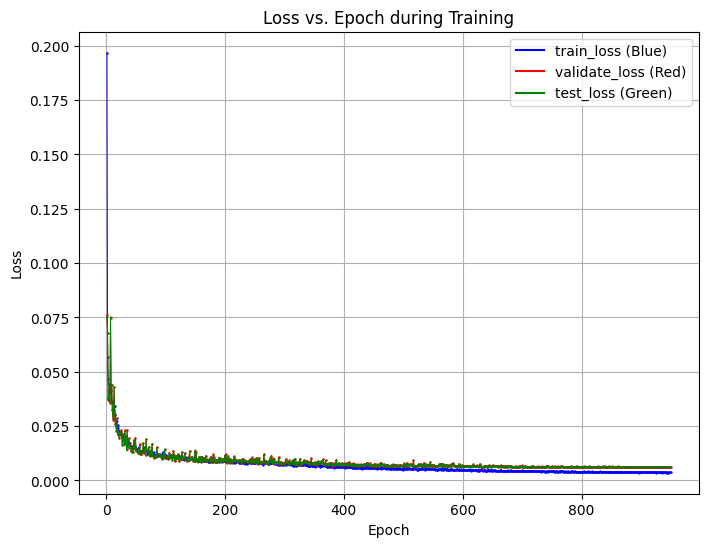

epoch:999 train:0.0037 valid:0.0061 test:0.006 lr:0.0003876 best_test:0.006:  10%|▉         | 1000/10001 [1:10:39<10:31:28,  4.21s/it] 

Saving data...
MAE loss:  0.05853068828582764


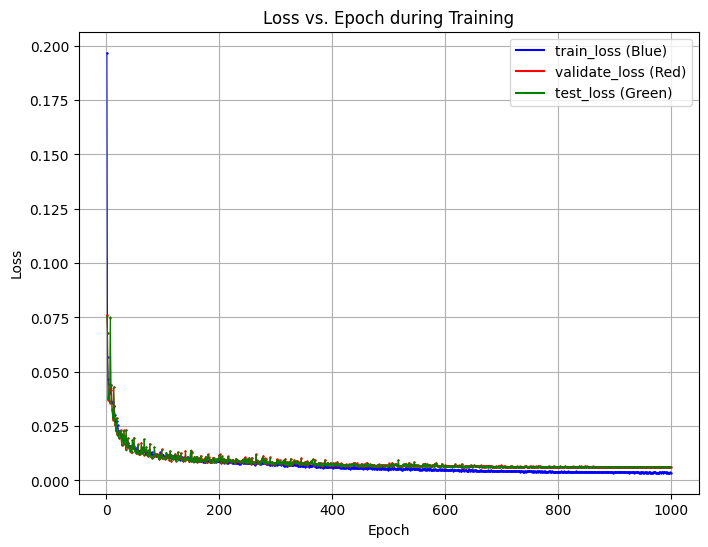

MAE=  0.05853069076773485
Saving model...


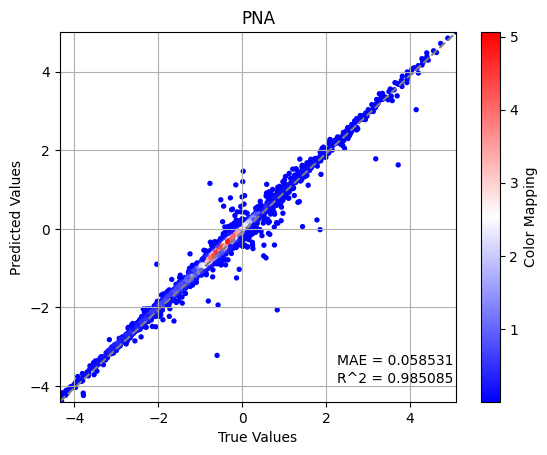

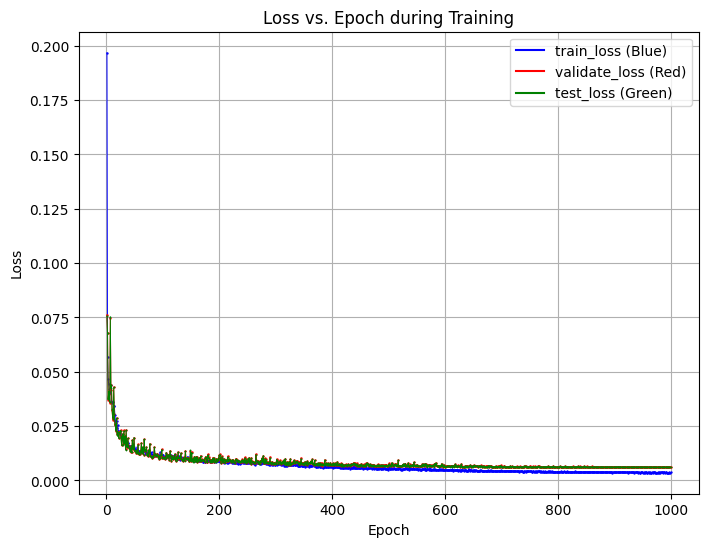

epoch:1049 train:0.0036 valid:0.0061 test:0.006 lr:0.00028004 best_test:0.006:  10%|█         | 1050/10001 [1:14:10<10:31:47,  4.23s/it] 

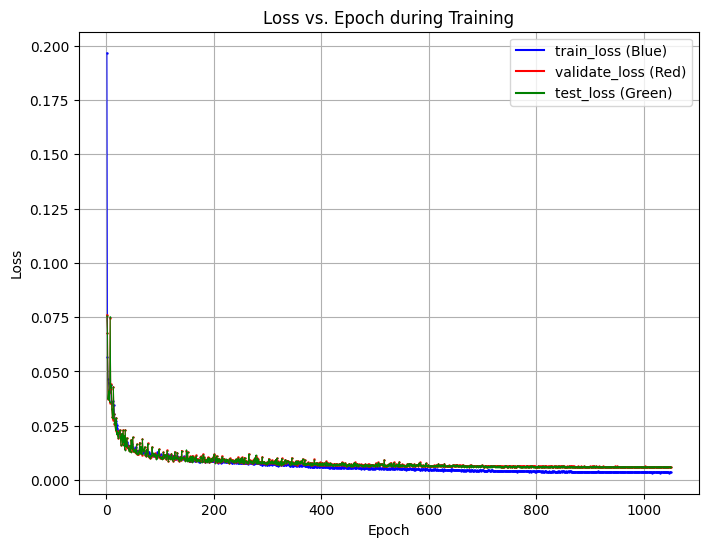

epoch:1099 train:0.0036 valid:0.0061 test:0.006 lr:0.00028004 best_test:0.006:  11%|█         | 1100/10001 [1:17:40<10:20:54,  4.19s/it] 

Saving data...
MAE loss:  0.058158937841653824


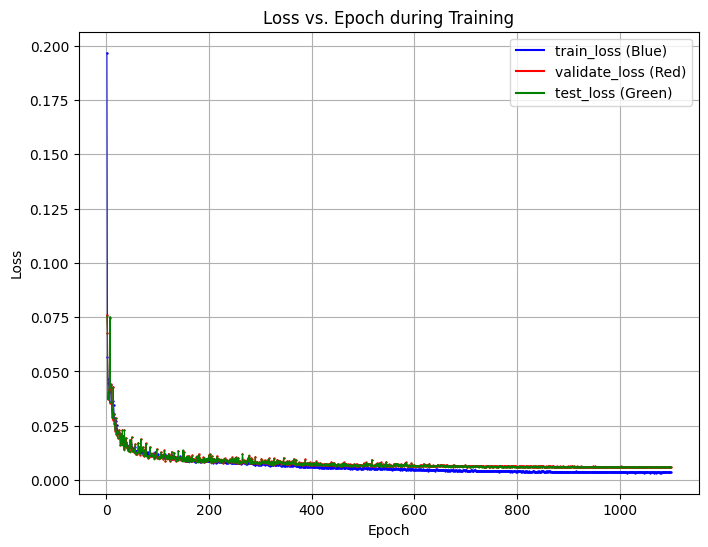

MAE=  0.05815893737125016
Saving model...


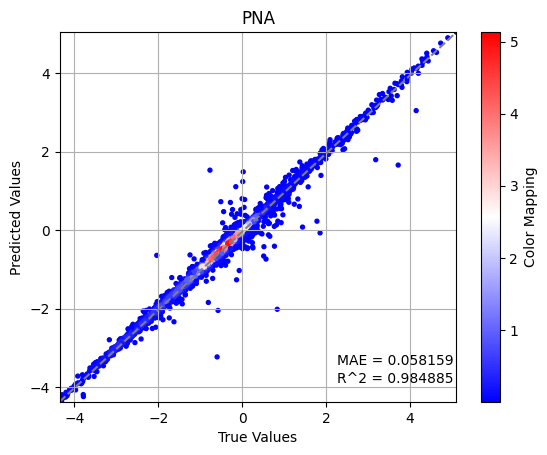

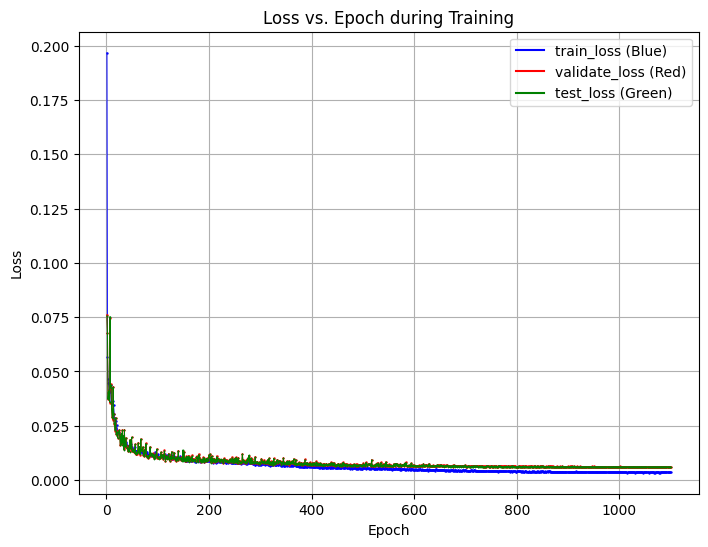

epoch:1149 train:0.0036 valid:0.0061 test:0.006 lr:0.00020233 best_test:0.006:  11%|█▏        | 1150/10001 [1:21:12<10:20:17,  4.20s/it] 

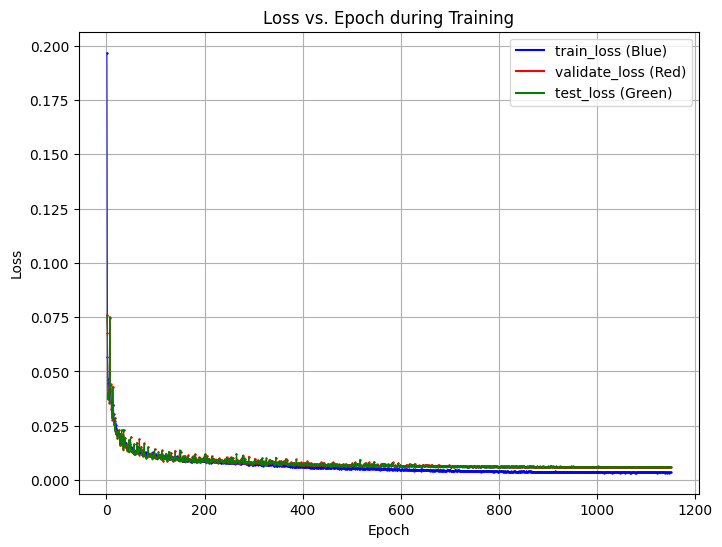

epoch:1199 train:0.0036 valid:0.0061 test:0.006 lr:0.00014618 best_test:0.006:  12%|█▏        | 1200/10001 [1:25:59<15:37:24,  6.39s/it]

Saving data...
MAE loss:  0.05867274850606918


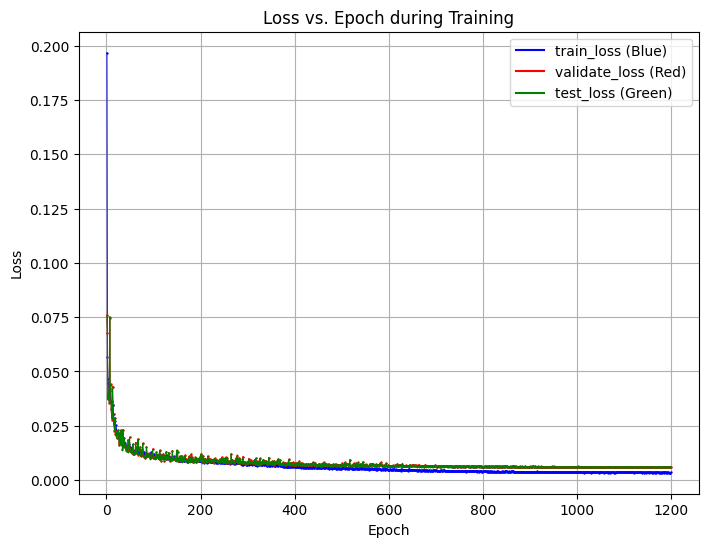

MAE=  0.05867274760657685
Saving model...


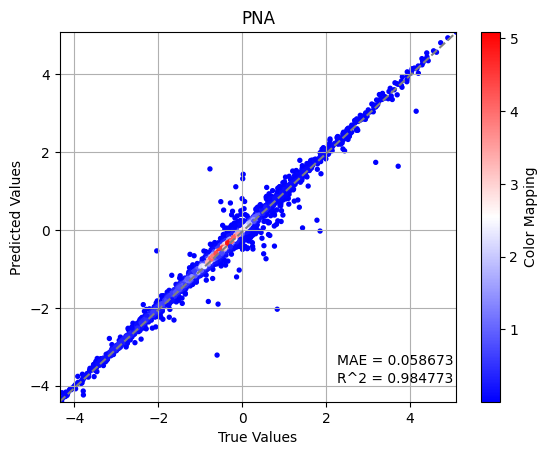

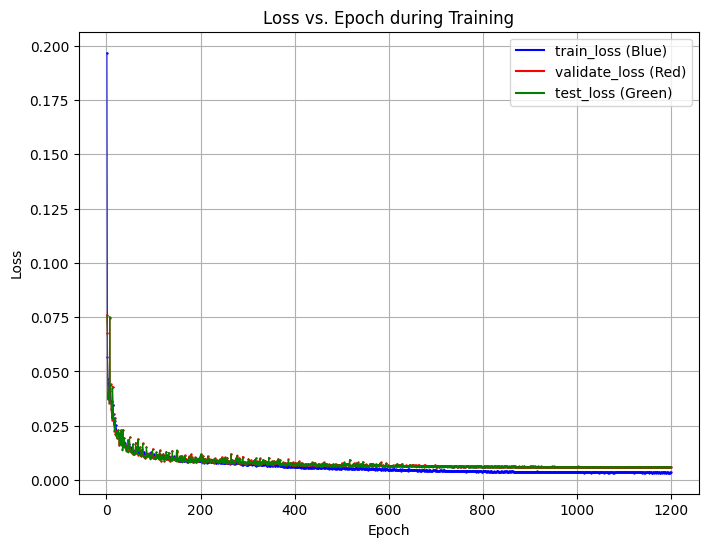

epoch:1249 train:0.0037 valid:0.0061 test:0.006 lr:0.00012425 best_test:0.006:  12%|█▏        | 1250/10001 [1:29:30<10:12:29,  4.20s/it]

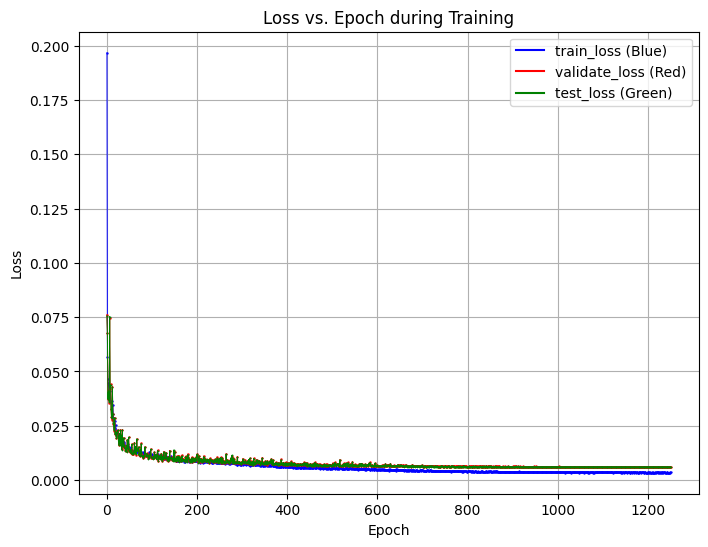

epoch:1299 train:0.0034 valid:0.0061 test:0.006 lr:8.977e-05 best_test:0.006:  13%|█▎        | 1300/10001 [1:33:01<10:14:34,  4.24s/it] 

Saving data...
MAE loss:  0.058172449469566345


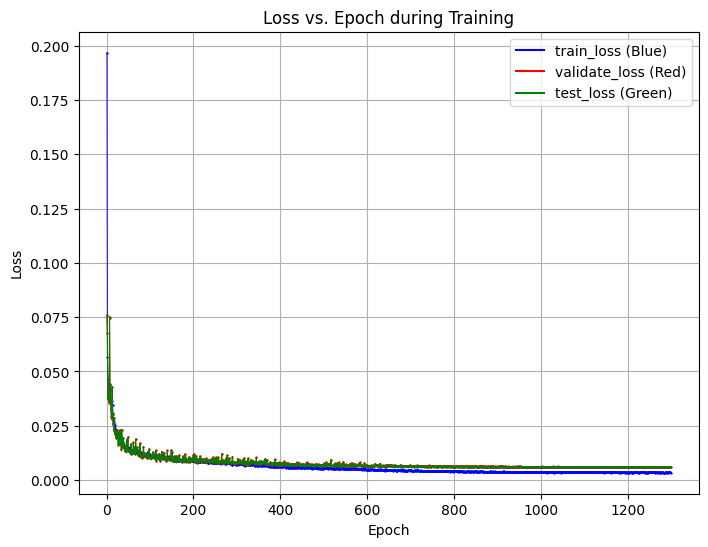

MAE=  0.05817244573061384
Saving model...


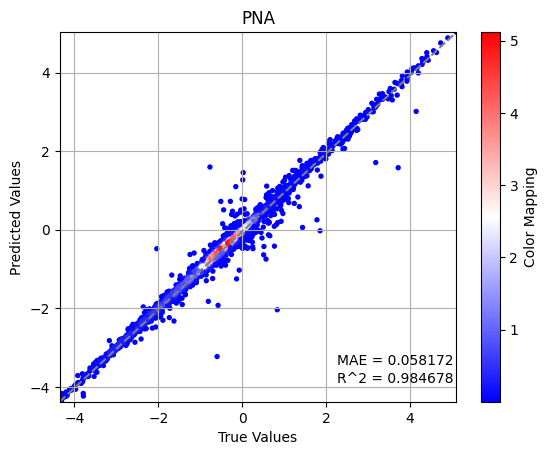

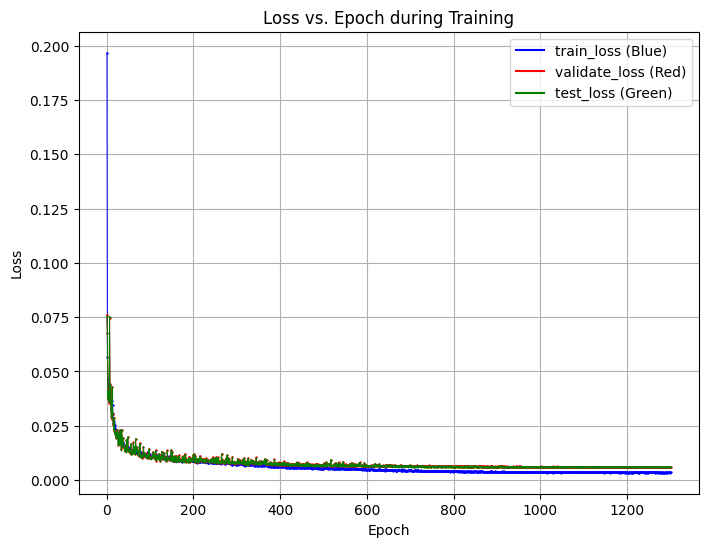

epoch:1300 train:0.0036 valid:0.0061 test:0.006 lr:8.977e-05 best_test:0.006:  13%|█▎        | 1301/10001 [1:33:07<11:29:06,  4.75s/it]

In [7]:
epoch_start = 0 if epoch is None else epoch
epoch = epoch_start - 1
epochs = model_args["epochs"]

pbar = tqdm(total=(epochs + 1))
pbar.update(epoch_start + 1)

for epoch in range(epoch_start + 1, epochs + 1):

    # auto save and evaluate at every 100 epoch step
    save_result_data(
        args,
        epoch,
        model,
        train_losses,
        val_losses,
        test_losses,
        test_loader,
        test_dataset,
        device,
        optimizer,
        scheduler,
        result_path,
        regression_title=model_name,
        save_split=save_split,
        training=True,
    )

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    torch.cuda.empty_cache()
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    torch.cuda.empty_cache()
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)
    torch.cuda.empty_cache()

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=show_plot_split,threshold=0.2)

    # save best model
    if test_best_loss is None or test_loss < test_best_loss:
        test_best_loss = test_loss
        # save_model_GCN(epoch, model, optimizer, scheduler, result_path)

    progress_msg = (
        "epoch:"
        + str(epoch)
        + " train:"
        + str(round(train_loss, 4))
        + " valid:"
        + str(round(val_loss, 4))
        + " test:"
        + str(round(test_loss, 4))
        + " lr:"
        + str(round(current_lr, 8))
        + " best_test:"
        + str(round(test_best_loss, 4))
    )
    pbar.set_description(progress_msg)
    pbar.update(1)

pbar.close()

Save model, results and checkpoint if need

In [ ]:
save_result_data(
    args,
    epoch,
    model,
    train_losses,
    val_losses,
    test_losses,
    test_loader,
    test_dataset,
    optimizer,
    scheduler,
    device,
    result_path,
    regression_title=model_name,
)

Get test data distribution

In [ ]:
# reverse data scale
min, max = get_data_scale(args)

test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print(loss)

plt.hist(test_y.to("cpu"), range=(-5, 5), bins=50)